In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import pyscad

In [2]:
reload(pyscad)
from pyscad import *

## Testing Rounded Interval Arithmatic

Floating point arithmatic gives some strange behavior.

In [3]:
a = 0.2
b = 0.6
print(f'a={a}, b={b}, a+a+a == b evaluates to : {a+a+a == b}')

a=0.2, b=0.6, a+a+a == b evaluates to : False


Using interval arithmatic we can now make these comparisons

In [4]:
a = flint.frac(2,10)
b = flint.frac(6,10)
print(f'a={a}, b={b}, a+a+a == b evaluates to : {a+a+a == b}')

a=0.2, b=0.6, a+a+a == b evaluates to : True


We can also use flints (floating point intervals) in matplotlib graphs

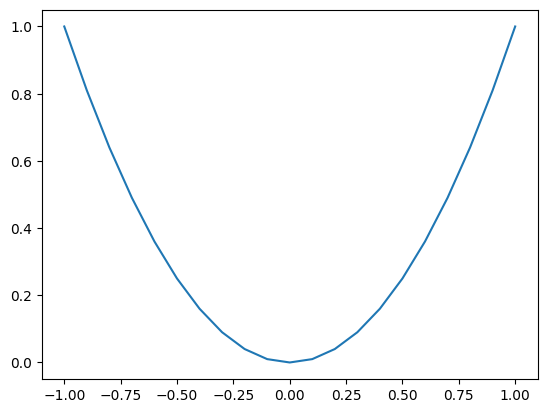

In [5]:
x = [flint(i/10.) for i in range(-10,11)]
y = [xp*xp for xp in x]
plt.plot(x,y)

## B-Splines

We can form a basis spline by defining control points and a knot-vector.

In [6]:
# Here we will just make an arbitrary basis spline
# degree
p = 3
# control points
c = np.array([[-2,-1],
              [-3, 3],
              [0,1],
              [3,3],
              [2,-1]])
# knot-vector need p repeated control points at start and finish
t = [0.0]*p + list(np.linspace(0,1,len(c)+1-p)) + [1.0]*p
# Create the spline
b = BSpline(c,p,t)

We can evaluate the spline along its length and plot it.

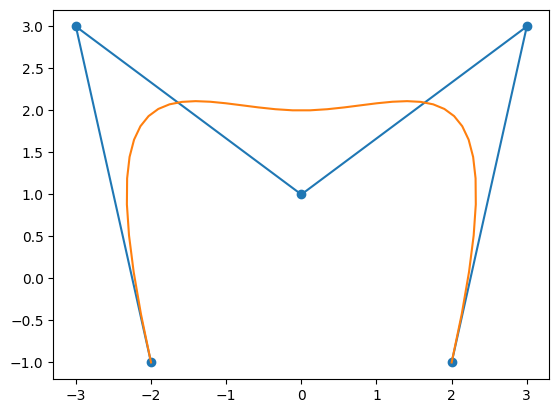

In [7]:
# Get the control points and points along the spline
cpts = b.c
pts = b(np.linspace(0,1,40))
# The points are list of (x,y) pairs. So to plot them with matplotlib we have to turn
# them into two seperate list of x and y positions
# You can either to this explicilty manipulating the numpy arrays
plt.plot(*(cpts.T),'o-')
# Or you can use the to_comp (to components) convenience function in the cpoints
# submodule
plt.plot(*(cpoint.to_comp(pts)))

We can also evaluate the b-splines first and second derivatives, which are just other
basis splines one degree less.

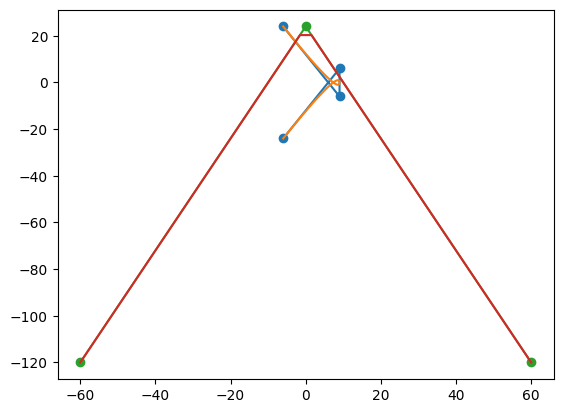

In [8]:
cpts = b.t.d_cpts(b.c, b.p)
pts = b.d(np.linspace(0,1,40))
plt.plot(*(cpoint.to_comp(cpts[1:-1])),'o-')
plt.plot(*(cpoint.to_comp(pts)))
cpts = b.t.d_cpts(cpts, b.p-1)
pts = b.d(np.linspace(0,1,40), 2)
plt.plot(*(cpoint.to_comp(cpts[2:-2])),'o-')
plt.plot(*(cpoint.to_comp(pts)))

## NURBS curves

The power of NURBS curves is that they can exactly represent conic sections such as a circle, so we'll do exactly that.

In [9]:
# The following control points and weights define a full circle.
r = 3 # < radius 3
p = 2 # < degree 2
c = [[r,0],[r,r],[0,r],[-r,r],[-r,0],[-r,-r],[0,-r],[r,-r],[r,0]]
w0 = 1/np.sqrt(2)
w = [1,w0,1,w0,1,w0,1,w0,1]
t = [0,0,0,0.25,0.25,0.5,0.5,0.75,0.75,1,1,1]
s = NurbsCurve(c,w,p,t)

We can still evaluate and plot the curve as with non-rational b-splines.

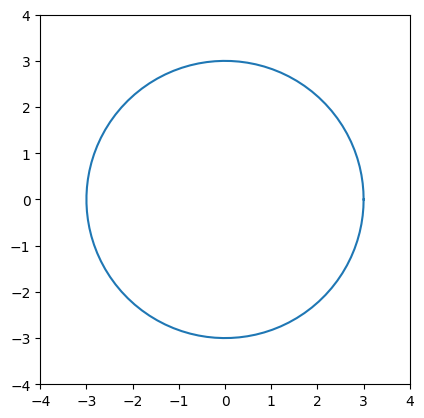

In [10]:
# We can still evaluate the curve the same way
pts = s(np.linspace(0,1,100))
x,y = cpoint.to_comp(pts)
# We can plot it as normal as well
fig = plt.Figure()
ax = fig.add_subplot()
ax.plot(x,y)
# But we might want to take a little more care in plotting by explicitly setting aspect 
# and limits
ax.set_aspect(1)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)

fig

The parameter `t` in the curve does not correspond to arc-length. But we can use the
`arclen` method to compare the relative difference.

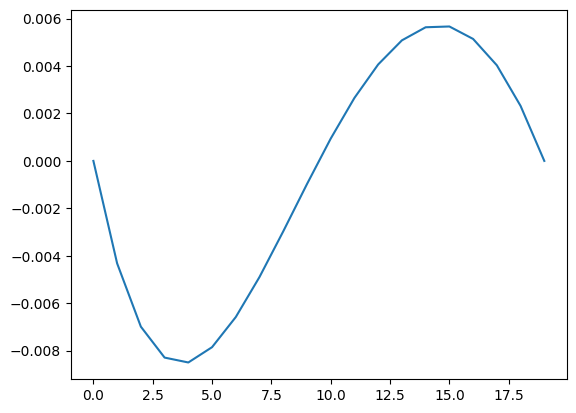

In [11]:
# We'll look at points over a quarter circle
dt = np.linspace(0.25,0.5,20)
ds = np.zeros_like(dt)
# Note for reasons unknown (read: poorly structured code) this takes awhile
for i, t in enumerate(dt):
     ds[i] = s.arclen(0,t)
# Rescale the points by the full circumference
dt = 2*np.pi*r*dt
# Plot the relative difference
plt.plot((ds-dt)/ds)

We can use matplotlib's quiver function to plot the tangent points on the curve. Note:
unlike the simple plot function, the quiver function does not like the flint objects
so I had to cast them into floats, for plotting.

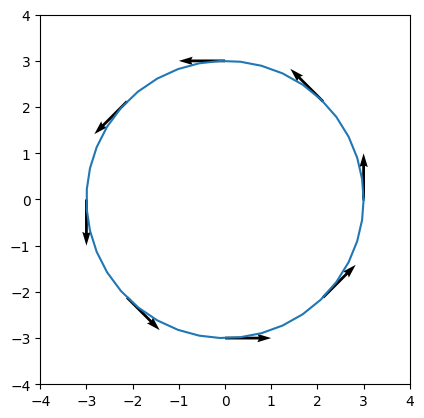

In [12]:
# Get a dense set of points for the primary plot
circ_pts = s(np.linspace(0,1,40))
# Use a smaller number of points for the tangent vectors
t = np.linspace(0,1,8,endpoint=False)
x, y = cpoint.to_comp(s(t).astype(float))
u, v = cpoint.to_comp(s.tangent(t).astype(float))
# Set the aspect ratio and plot range manually
fig = plt.Figure()
ax = fig.add_subplot()
ax.set_aspect(1)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
# Add the circle
ax.plot(*cpoint.to_comp(circ_pts))
# And add the tangent plots
ax.quiver(x,y,u,v, angles='xy', scale_units='xy', scale=1)

fig

## Nurbs surface

Nurbs sufaces can be used to define _exactly_ many more complicated surfaces, such as a torus.

In [13]:
r = 2 # < radius of center of the ring
a = 1 # < radius of smaller cross-section circle of the ring
# Control point points for the two circles
cXY = [[r,0],[r,r],[0,r],[-r,r],[-r,0],[-r,-r],[0,-r],[r,-r],[r,0]]
cXZ = [[a,0],[a,a],[0,a],[-a,a],[-a,0],[-a,-a],[0,-a],[a,-a],[a,0]]
# Combining these two control point vectors into a control point array
# Start with empty array of right size we combine the points paying close
# attention to how we add or subtract points to the x and y components
c = [[[0.0, 0.0, 0.0] for _ in cXZ] for _ in cXY]
for i, XY in enumerate(cXY):
    for j, XZ in enumerate(cXZ):
        x, y = XY
        aa, z = XZ
        sgx, sgy = np.sign([x,y])
        c[i][j][0] = x + sgx*aa # < X component
        c[i][j][1] = y + sgy*aa # < Y component
        c[i][j][2] = z # < Z component 
p = 2 # < degree 2
w0 = 1/np.sqrt(2)
ww = [1,w0,1,w0,1,w0,1,w0,1]
# The weights will be the direct product of the individual weights
w = [[wwA*wwB for wwA in ww] for wwB in ww]
t = [0,0,0,0.25,0.25,0.5,0.5,0.75,0.75,1,1,1]
s = NurbsSurf(c,w,p,p,t,t)

Because we did some ... questionable math in forming the control points, lets just plot the control points to make sure they make a kind-of square box with a square hole in it.

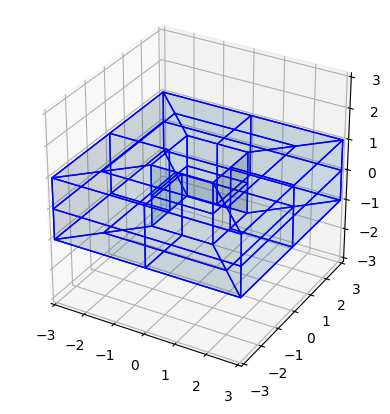

In [14]:
x,y,z = cpoint.to_comp(s.c.astype(float))
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set(xlim=[-3,3],ylim=[-3,3],zlim=[-3,3])
ax.set_aspect('equal')
ax.plot_surface(x,y,z, edgecolor='blue', alpha=0.1)

Now we can evaluate the surface over it's range and plot it. Note: Similar to the quiver-plot in 2-D, the 3-D plot does not like flint objects, so we need to cast them to floats before plotting.

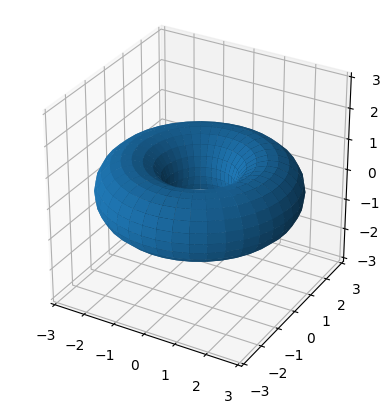

In [15]:
U, V = np.meshgrid(np.linspace(0,1,40), np.linspace(0,1,20))
pts = s(U,V).astype(float)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set(xlim=[-3,3],ylim=[-3,3],zlim=[-3,3])
ax.set_aspect('equal')
ax.plot_surface(*cpoint.to_comp(pts))